In [3]:
!pip install roboflow
!pip install ultralytics
import torch
import os
import cv2
import time
import glob
import json
import torch
import random
%matplotlib inline
import numpy as np
import torch.optim as optim
from tqdm import tqdm
from ultralytics import YOLO
from roboflow import Roboflow
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.4/80.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.7/882.7 kB 23.2 MB/s eta 0:00:0000:01
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
rf = Roboflow(api_key="3nPGQCKqlCIXnWOgAKqx")
project = rf.workspace("waterdetection-lsvva").project("detection_water")
version = project.version(4)
dataset = version.download("yolov9")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Detection_water-4 in yolov9:: 100%|██████████| 6472/6472 [00:01<00:00, 5410.42it/s]


In [7]:
detection_folder = "/kaggle/working/Detection_water-4"

def count_jpg_files(folder):
    jpg_files = glob.glob(os.path.join(folder, '**', '*.jpg'), recursive=True)
    return len(jpg_files)

train_folder = os.path.join(detection_folder, "train", "images")
test_folder = os.path.join(detection_folder, "test", "images")
val_folder = os.path.join(detection_folder, "valid", "images")

train_jpg_count = count_jpg_files(train_folder)
test_jpg_count = count_jpg_files(test_folder)
val_jpg_count = count_jpg_files(val_folder)

print(f"Number of .jpg files in 'train': {train_jpg_count}")
print(f"Number of .jpg files in 'test': {test_jpg_count}")
print(f"Number of .jpg files in 'val': {val_jpg_count}")

Number of .jpg files in 'train': 2423
Number of .jpg files in 'test': 481
Number of .jpg files in 'val': 326


In [8]:
classes = []
class SimpleAugmentation:
    def __init__(self, image_filename, image_ext, label_filename):
        assert os.path.isfile(image_filename), f"Image file {image_filename} not found."
        assert os.path.isfile(label_filename), f"YOLO label file {label_filename} not found."

        self.image_filename = image_filename
        self.image_ext = image_ext
        self.image = cv2.imread(self.image_filename, 1)
        self.image = cv2.resize(self.image, (640, 640))
        self.original_size = (self.image.shape[1], self.image.shape[0])
        self.bboxes = self.read_bboxes(label_filename)

    def read_bboxes(self, label_filename):
        bboxes = []
        with open(label_filename, 'r') as f:
            for line in f:
                values = list(filter(None, line.strip().split()))
                if len(values) == 5:
                    class_id, x_center, y_center, width, height = map(float, values)
                    bboxes.append((int(class_id), x_center, y_center, width, height))
                else:
                    print(f"Skipping line in {label_filename}: {line.strip()} (expected 5 values, got {len(values)})")
        return bboxes

    def augment_image(self):
        augmented_images = []
        new_bboxes_list = []

        # Horizontal flip
        h_flip = cv2.flip(self.image, 1)
        augmented_images.append(h_flip)
        new_bboxes_list.append(self.update_bboxes_for_flip(self.bboxes, flip=True))

        # Vertical flip
        v_flip = cv2.flip(self.image, 0)
        augmented_images.append(v_flip)
        new_bboxes_list.append(self.update_bboxes_for_flip(self.bboxes, flip=False))

        # Rotation by 10 degrees
        rotation_angle = 10
        rotated_image = self.rotate_image(self.image, rotation_angle)
        augmented_images.append(rotated_image)
        new_bboxes_list.append(self.update_bboxes_for_rotation(self.bboxes, rotation_angle))

        return augmented_images, new_bboxes_list

    def rotate_image(self, image, angle):
        center = (image.shape[1] // 2, image.shape[0] // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        return cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]))

    def update_bboxes_for_flip(self, bboxes, flip=True):
        new_bboxes = []
        for class_id, x_center, y_center, width, height in bboxes:
            if flip:  # Horizontal flip
                x_center = 1 - x_center
            else:  # Vertical flip
                y_center = 1 - y_center
            new_bboxes.append((class_id, x_center, y_center, width, height))
        return new_bboxes

    def update_bboxes_for_rotation(self, bboxes, angle):
        angle_rad = np.radians(angle)
        new_bboxes = []
        for class_id, x_center, y_center, width, height in bboxes:
            # Convert normalized values to pixel values
            x_center_pix = x_center * self.original_size[0]
            y_center_pix = y_center * self.original_size[1]
            width_pix = width * self.original_size[0]
            height_pix = height * self.original_size[1]

            # Calculate corners of the bounding box
            x1 = x_center_pix - width_pix / 2
            y1 = y_center_pix - height_pix / 2
            x2 = x_center_pix + width_pix / 2
            y2 = y_center_pix + height_pix / 2

            # Define box points for rotation
            box_points = np.array([[x1, y1], [x2, y1], [x2, y2], [x1, y2]])
            center = (self.original_size[0] / 2, self.original_size[1] / 2)
            rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
            rotated_points = cv2.transform(np.array([box_points]), rotation_matrix)[0]

            # Calculate new center and dimensions of the bounding box
            new_x_center = (rotated_points[:, 0].max() + rotated_points[:, 0].min()) / (2 * self.original_size[0])
            new_y_center = (rotated_points[:, 1].max() + rotated_points[:, 1].min()) / (2 * self.original_size[1])
            new_width = (rotated_points[:, 0].max() - rotated_points[:, 0].min()) / self.original_size[0]
            new_height = (rotated_points[:, 1].max() - rotated_points[:, 1].min()) / self.original_size[1]

            new_bboxes.append((class_id, new_x_center, new_y_center, new_width, new_height))
        return new_bboxes

    def save_augmented_images(self, output_images_dir, output_labels_dir):
        augmented_images, new_bboxes_list = self.augment_image()
        base_name = os.path.basename(self.image_filename).replace(self.image_ext, "")

        for i, aug_image in enumerate(augmented_images):
            output_image_path = os.path.join(output_images_dir, f"{base_name}_aug_{i}{self.image_ext}")
            cv2.imwrite(output_image_path, aug_image)

            bbox_file_name = f"{base_name}_aug_{i}.txt"
            bbox_output_path = os.path.join(output_labels_dir, bbox_file_name)
            with open(bbox_output_path, 'w') as fout:
                for bbox in new_bboxes_list[i]:
                    fout.write(f"{bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]} {bbox[4]}\n")

            print(f"Saved: {bbox_output_path}")

def plot_bounding_box(image, bbox):
    
    fig, ax = plt.subplots(1)
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    img_height, img_width = image.shape[:2]

    x_center, y_center, width, height = bbox
    
    x1 = max(0, (x_center - width / 2) * img_width)
    y1 = max(0, (y_center - height / 2) * img_height)
    x2 = min(img_width, (x_center + width / 2) * img_width)
    y2 = min(img_height, (y_center + height / 2) * img_height)


    clipped_width = x2 - x1
    clipped_height = y2 - y1

    rect = patches.Rectangle((x1, y1), clipped_width, clipped_height, linewidth=2, edgecolor='r', facecolor='none')

    ax.add_patch(rect)
    plt.show()

In [9]:
if __name__ == "__main__":
    input_images_dir = "/kaggle/working/Detection_water-4/train/images"
    input_labels_dir = "/kaggle/working/Detection_water-4/train/labels"
    output_images_dir = "/kaggle/working/Detection_water-4/output1/images/"
    output_labels_dir = "/kaggle/working/Detection_water-4/output1/labels/"

    os.makedirs(output_images_dir, exist_ok=True)
    os.makedirs(output_labels_dir, exist_ok=True)

    ext = ["jpg", "png"]
    for e in ext:
        files = glob.glob(os.path.join(input_images_dir, '*.' + e))
        for filepath in files:
            image_name, image_ext = os.path.splitext(filepath)
            image_base_name = os.path.basename(image_name)

            print(f"Processing image file: {image_name + image_ext}")
            label_file = os.path.join(input_labels_dir, f"{image_base_name}.txt")

            aug = SimpleAugmentation(image_name + image_ext, image_ext, label_file)
            aug.save_augmented_images(output_images_dir, output_labels_dir)

Processing image file: /kaggle/working/Detection_water-4/train/images/EMDS7-G022-125-0400_png.rf.503af92ff4b7f81640191447cde2dca7.jpg
Saved: /kaggle/working/Detection_water-4/output1/labels/EMDS7-G022-125-0400_png.rf.503af92ff4b7f81640191447cde2dca7_aug_0.txt
Saved: /kaggle/working/Detection_water-4/output1/labels/EMDS7-G022-125-0400_png.rf.503af92ff4b7f81640191447cde2dca7_aug_1.txt
Saved: /kaggle/working/Detection_water-4/output1/labels/EMDS7-G022-125-0400_png.rf.503af92ff4b7f81640191447cde2dca7_aug_2.txt
Processing image file: /kaggle/working/Detection_water-4/train/images/EMDS7-G008-010-0400_png.rf.477644f5a3afdbf518ef15b6d8159f29.jpg
Saved: /kaggle/working/Detection_water-4/output1/labels/EMDS7-G008-010-0400_png.rf.477644f5a3afdbf518ef15b6d8159f29_aug_0.txt
Saved: /kaggle/working/Detection_water-4/output1/labels/EMDS7-G008-010-0400_png.rf.477644f5a3afdbf518ef15b6d8159f29_aug_1.txt
Saved: /kaggle/working/Detection_water-4/output1/labels/EMDS7-G008-010-0400_png.rf.477644f5a3afdbf518e

In [15]:
detection_folder = "/kaggle/working/Detection_water-4/output1"
image_folder = os.path.join(detection_folder, "images")
label_folder = os.path.join(detection_folder, "labels/")

Visualizing image: /kaggle/working/Detection_water-4/output1/images/EMDS7-G016-003-0400_png.rf.63b7fb361e7484f1831e89fa38ee4452_aug_0.jpg
Expected label path: /kaggle/working/Detection_water-4/output1/labels/EMDS7-G016-003-0400_png.rf.63b7fb361e7484f1831e89fa38ee4452_aug_0.txt


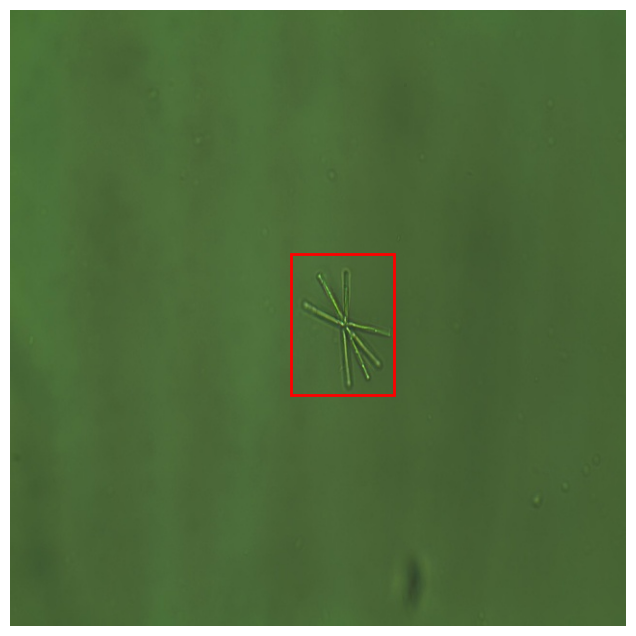

Visualizing image: /kaggle/working/Detection_water-4/output1/images/EMDS7-G039-080-0400_png.rf.9f82842ec6e2a7cde37163f0fd700a3a_aug_2.jpg
Expected label path: /kaggle/working/Detection_water-4/output1/labels/EMDS7-G039-080-0400_png.rf.9f82842ec6e2a7cde37163f0fd700a3a_aug_2.txt


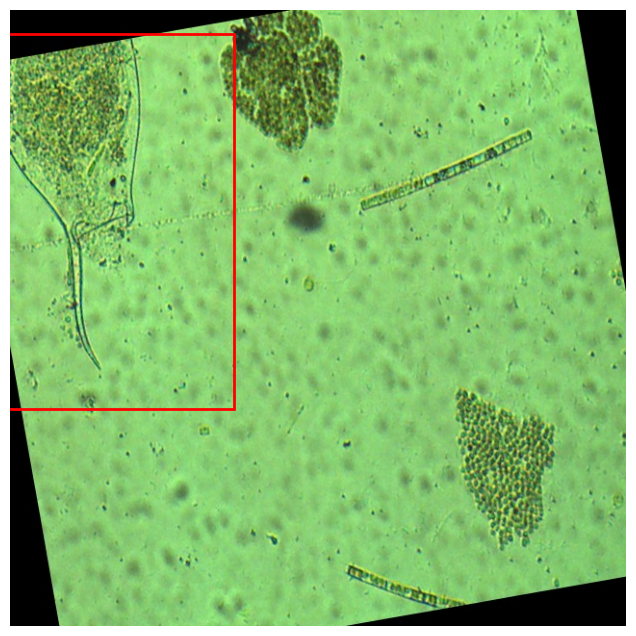

Visualizing image: /kaggle/working/Detection_water-4/output1/images/EMDS7-G024-003-0400_png.rf.0035c292c06a4ebde83df5a8c791ac13_aug_2.jpg
Expected label path: /kaggle/working/Detection_water-4/output1/labels/EMDS7-G024-003-0400_png.rf.0035c292c06a4ebde83df5a8c791ac13_aug_2.txt


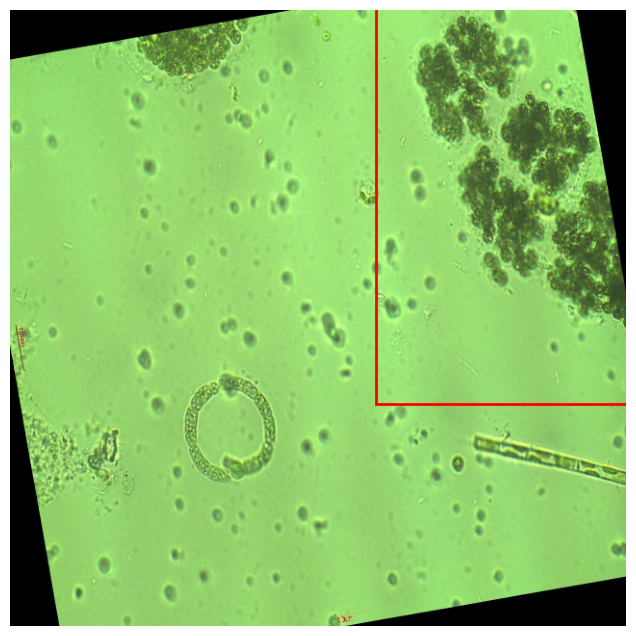

Visualizing image: /kaggle/working/Detection_water-4/output1/images/EMDS7-G018-061-0400_png.rf.6104541a54db7fc1021644fd1f85e4c4_aug_2.jpg
Expected label path: /kaggle/working/Detection_water-4/output1/labels/EMDS7-G018-061-0400_png.rf.6104541a54db7fc1021644fd1f85e4c4_aug_2.txt


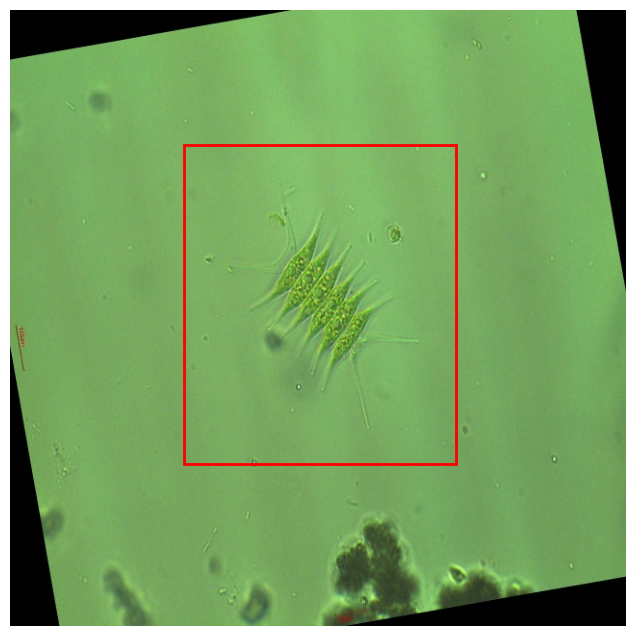

Visualizing image: /kaggle/working/Detection_water-4/output1/images/EMDS7-G015-016-0400_png.rf.269746d75306251eb535f08dcbd753a0_aug_1.jpg
Expected label path: /kaggle/working/Detection_water-4/output1/labels/EMDS7-G015-016-0400_png.rf.269746d75306251eb535f08dcbd753a0_aug_1.txt


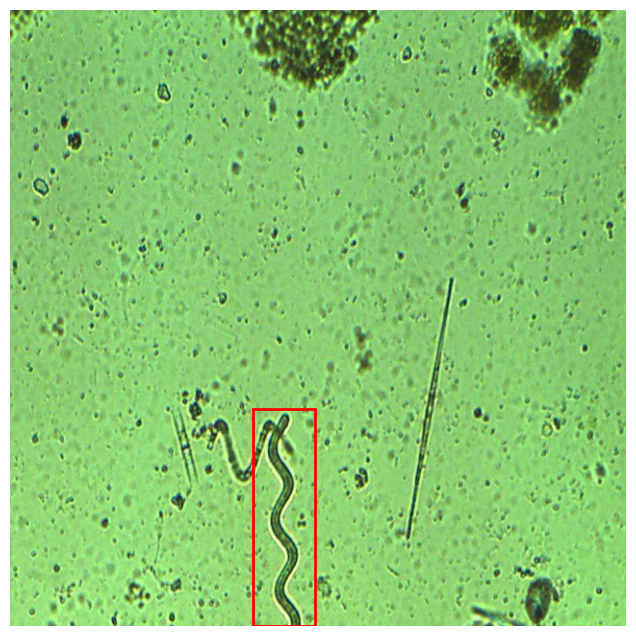

Visualizing image: /kaggle/working/Detection_water-4/output1/images/EMDS7-G003-196-0400_png.rf.c4d0b9b9db6030d1103d5079da6a914e_aug_2.jpg
Expected label path: /kaggle/working/Detection_water-4/output1/labels/EMDS7-G003-196-0400_png.rf.c4d0b9b9db6030d1103d5079da6a914e_aug_2.txt


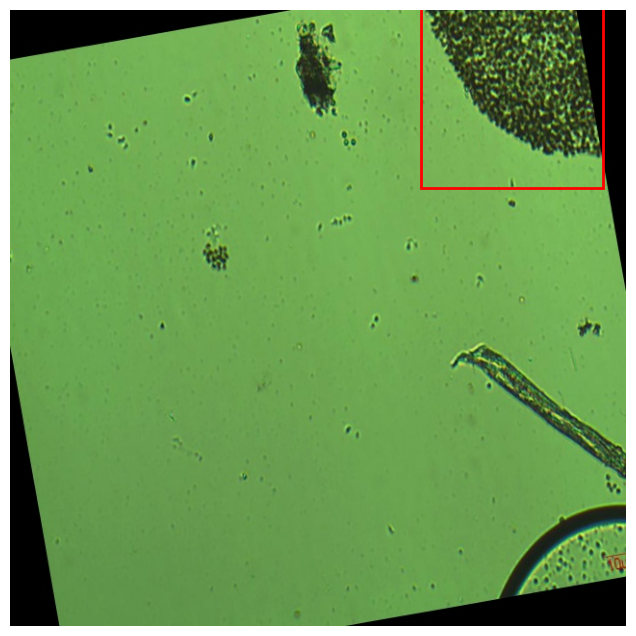

Visualizing image: /kaggle/working/Detection_water-4/output1/images/EMDS7-G003-103-0400_png.rf.13e93c8791594f29aa91712e2a3cc3a7_aug_2.jpg
Expected label path: /kaggle/working/Detection_water-4/output1/labels/EMDS7-G003-103-0400_png.rf.13e93c8791594f29aa91712e2a3cc3a7_aug_2.txt


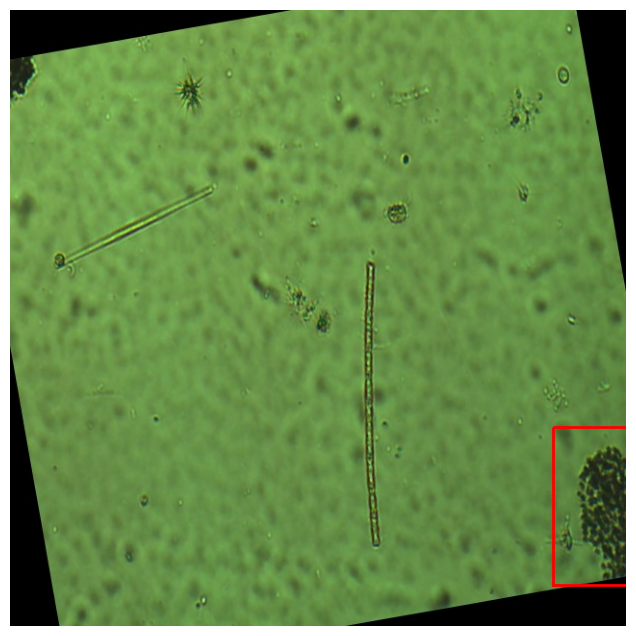

Visualizing image: /kaggle/working/Detection_water-4/output1/images/EMDS7-G003-001-0400_png.rf.3c4af2732dffbf2a01457dc08e1d6e0c_aug_2.jpg
Expected label path: /kaggle/working/Detection_water-4/output1/labels/EMDS7-G003-001-0400_png.rf.3c4af2732dffbf2a01457dc08e1d6e0c_aug_2.txt


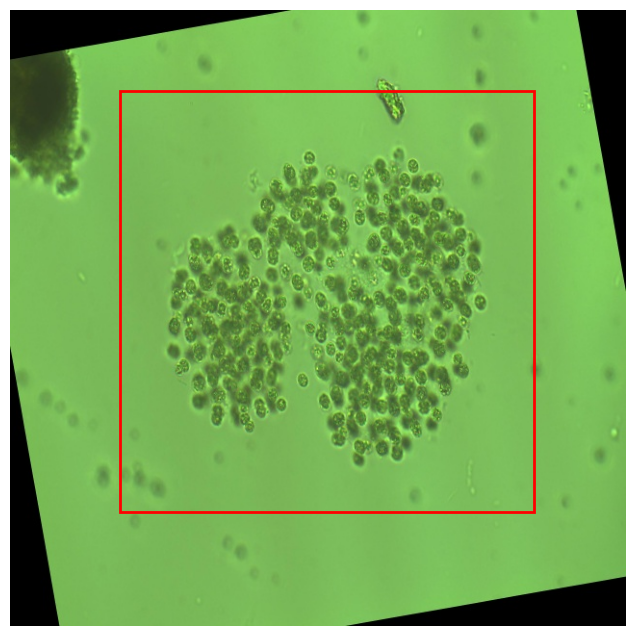

Visualizing image: /kaggle/working/Detection_water-4/output1/images/EMDS7-G025-005-0400_png.rf.e94acf8a267b26b949dbc506f173678b_aug_2.jpg
Expected label path: /kaggle/working/Detection_water-4/output1/labels/EMDS7-G025-005-0400_png.rf.e94acf8a267b26b949dbc506f173678b_aug_2.txt


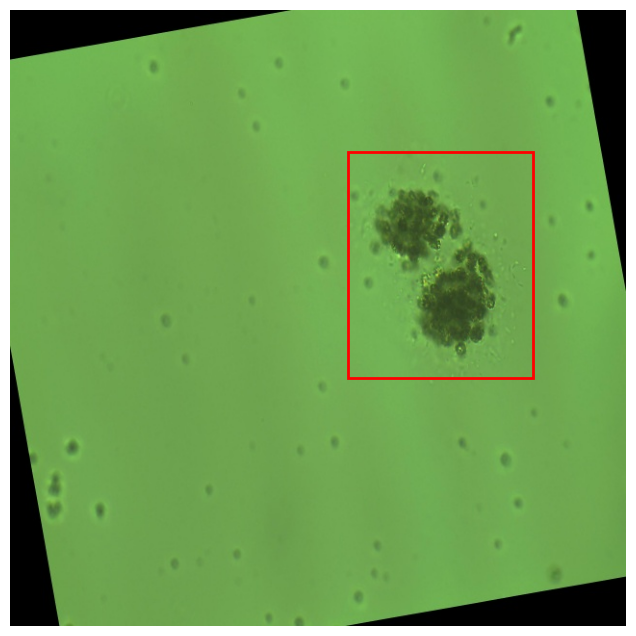

Visualizing image: /kaggle/working/Detection_water-4/output1/images/EMDS7-G023-046-0400_png.rf.c700cf345da27df1403500c50a4f0eed_aug_0.jpg
Expected label path: /kaggle/working/Detection_water-4/output1/labels/EMDS7-G023-046-0400_png.rf.c700cf345da27df1403500c50a4f0eed_aug_0.txt


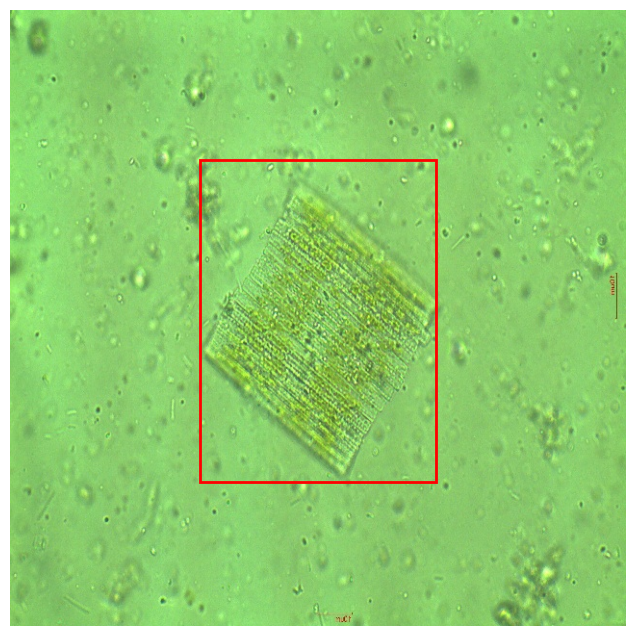

In [23]:
def visualize_image_with_bbox(image_path, label_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Image file {image_path} not found.")
        return

    h, w = image.shape[:2]
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    try:
        with open(label_path, 'r') as f:
            bboxes = f.readlines()
    except FileNotFoundError:
        print(f"Label file {label_path} not found.")
        return

    plt.figure(figsize=(12, 8))
    plt.imshow(image_rgb)

    for bbox in bboxes:
        bbox = bbox.strip().split()
        class_id, x_center, y_center, box_width, box_height = map(float, bbox)

        x_center = int(x_center * w)
        y_center = int(y_center * h)
        box_width = int(box_width * w)
        box_height = int(box_height * h)

        x1 = int(x_center - (box_width / 2))
        y1 = int(y_center - (box_height / 2))
        x2 = int(x_center + (box_width / 2))
        y2 = int(y_center + (box_height / 2))

        rect = plt.Rectangle((x1, y1), box_width, box_height, edgecolor='red', facecolor='none', linewidth=2)
        plt.gca().add_patch(rect)

    plt.axis('off')  
    plt.show()  
    plt.close()  

image_folder = '/kaggle/working/Detection_water-4/output1/images'  
label_folder = '/kaggle/working/Detection_water-4/output1/labels'  

image_files = glob.glob(os.path.join(image_folder, "*.jpg"))
for image_filepath in image_files[:10]:  # Visualize the first 10 images
    base_name = os.path.basename(image_filepath)
    label_filename = base_name.replace(".jpg", ".txt")
    label_filepath = os.path.join(label_folder, label_filename)

    print(f"Visualizing image: {image_filepath}")
    print(f"Expected label path: {label_filepath}")
    visualize_image_with_bbox(image_filepath, label_filepath)

In [3]:
file_path = "/kaggle/working/Detection_water-3/data.yaml"

# Read the contents of the data.yaml file
with open(file_path, 'r') as file:
    content = file.read()

# Print the content to verify
print(content)

names:
- Acanthamoeba-0
- Achnanthes-1
- Actinastrum-1
- Actinophrys-1
- Anabaenopsis-0
- Ankistrodesmus-1
- Arcella-1
- Aspidisca-1
- Brachionus-1
- Burkholderia-0
- Campylobacter-0
- Chaenea-1
- Characium-1
- Chlorella-1
- Cocconeis-1
- Codosiga-1
- Coelastrum-1
- Coelosphaerium-0
- Colpoda-1
- Cosmarium-1
- Crucigenia-1
- Diversicornis-1
- Ecolli-0
- Entamoeba-0
- Epistylis-1
- Euclanis-1
- Euglena-1
- Euglypha-1
- Fragilaria-0
- Giardia-0
- Golenkinia-1
- Gomphonema-0
- Gomphosphaeria-0
- Gonyaulax-0
- Gymnodinium-0
- Keratella-1
- Merismopedia-0
- Microcystis-0
- Naegleria-0
- Navicula-1
- Noctiluca-1
- Oscillatoria-1
- Paramecium-1
- Pediastrum-0
- Phacus-1
- Phormidium-0
- Pinnularia-1
- Pompholyx-1
- Raphidiopsis-0
- Rotifera-1
- Salmonella-0
- Scenedesmus-1
- Shigella-0
- Siprostomum-1
- Sphaerocystis-1
- Spirogyra-1
- Spirulina-1
- Staurastrum-0
- Stentor-1
- Stylogaster-1
- Surirella-1
- Synchaeta-1
- Synedra-1
- Tetraedron-1
- Tribonema-1
- Vibrio-0
- Vorticella-1
- ceratiu

In [4]:
new_content = """
names:
- Acanthamoeba-0
- Achnanthes-1
- Actinastrum-1
- Actinophrys-1
- Anabaenopsis-0
- Ankistrodesmus-1
- Arcella-1
- Aspidisca-1
- Brachionus-1
- Burkholderia-0
- Campylobacter-0
- Chaenea-1
- Characium-1
- Chlorella-1
- Cocconeis-1
- Codosiga-1
- Coelastrum-1
- Coelosphaerium-0
- Colpoda-1
- Cosmarium-1
- Crucigenia-1
- Diversicornis-1
- Ecolli-0
- Entamoeba-0
- Epistylis-1
- Euclanis-1
- Euglena-1
- Euglypha-1
- Fragilaria-0
- Giardia-0
- Golenkinia-1
- Gomphonema-0
- Gomphosphaeria-0
- Gonyaulax-0
- Gymnodinium-0
- Keratella-1
- Merismopedia-0
- Microcystis-0
- Naegleria-0
- Navicula-1
- Noctiluca-1
- Oscillatoria-1
- Paramecium-1
- Pediastrum-0
- Phacus-1
- Phormidium-0
- Pinnularia-1
- Pompholyx-1
- Raphidiopsis-0
- Rotifera-1
- Salmonella-0
- Scenedesmus-1
- Shigella-0
- Siprostomum-1
- Sphaerocystis-1
- Spirogyra-1
- Spirulina-1
- Staurastrum-0
- Stentor-1
- Stylogaster-1
- Surirella-1
- Synchaeta-1
- Synedra-1
- Tetraedron-1
- Tribonema-1
- Vibrio-0
- Vorticella-1
- ceratium-1
nc: 68
roboflow:
  license: CC BY 4.0
  project: detection_water
  url: https://universe.roboflow.com/waterdetection-lsvva/detection_water/dataset/3
  version: 3
  workspace: waterdetection-lsvva
test: /kaggle/working/Detection_water-3/test/images
train: /kaggle/working/Detection_water-3/train/images
val: /kaggle/working/Detection_water-3/valid/images
"""
with open(file_path, 'w') as file:
    file.write(new_content)

print("data.yaml file updated successfully!")

data.yaml file updated successfully!


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device = {device}")

model = YOLO("yolov9c.pt")  

model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=0.001)

model.train(
    data="/kaggle/working/Detection_water-3/data.yaml",  
    epochs=50,         
    lr0=0.001,          
    save_period=10,     
    plots=True,
)

metrics = model.val() 

model = YOLO("./runs/detect/train/weights/best.pt")  

model.to(device)

device = cuda


100%|██████████| 49.4M/49.4M [00:00<00:00, 212MB/s] 


engine/trainer: task=detect, mode=train, model=yolov9c.pt, data=/kaggle/working/Detection_water-3/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=10, cache=False, device=cuda:0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, optimi

100%|██████████| 755k/755k [00:00<00:00, 14.4MB/s]
2024-10-12 08:20:22,734	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-10-12 08:20:23,586	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=68

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    212864  ultralytics.nn.modules.block.RepNCSPELAN4    [128, 256, 128, 64, 1]        
  3                  -1  1    164352  ultralytics.nn.modules.block.ADown           [256, 256]                    
  4                  -1  1    847616  ultralytics.nn.modules.block.RepNCSPELAN4    [256, 512, 256, 128, 1]       
  5                  -1  1    656384  ultralytics.nn.modules.block.ADown           [512, 512]                    
  6                  -1  1   2857472  ultralytics.nn.modules.block.RepNCSPELAN4    [512, 512, 512, 256, 1]       
  7                  -1  1    656384  ultralytic

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLO11n...


100%|██████████| 5.35M/5.35M [00:00<00:00, 69.2MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/Detection_water-3/train/labels... 7269 images, 54 backgrounds, 0 corrupt: 100%|██████████| 7269/7269 [00:06<00:00, 1073.03it/s]


train: New cache created: /kaggle/working/Detection_water-3/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 3, len(boxes) = 7224. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: 1.4.18 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
val: Scanning /kaggle/working/Detection_water-3/valid/labels... 326 images, 0 backgrounds, 0 corrupt: 100%|██████████| 326/326 [00:00<00:00, 1160.13it/s]

val: New cache created: /kaggle/working/Detection_water-3/valid/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 7, len(boxes) = 336. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000139, momentum=0.9) with parameter groups 160 weight(decay=0.0), 167 weight(decay=0.0005), 166 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      11.6G      1.415       4.58       1.67          9        640: 100%|██████████| 455/455 [06:05<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.47it/s]


                   all        326        336     0.0102      0.177     0.0169     0.0067

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      11.5G      1.427      3.195      1.658          9        640: 100%|██████████| 455/455 [05:58<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.72it/s]

                   all        326        336      0.208     0.0196     0.0203    0.00859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      11.5G      1.394      2.729      1.649         10        640: 100%|██████████| 455/455 [05:54<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.71it/s]

                   all        326        336      0.251     0.0791     0.0468      0.022



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      11.5G      1.376      2.427      1.643          6        640: 100%|██████████| 455/455 [05:53<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.71it/s]

                   all        326        336       0.19     0.0845     0.0619     0.0283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      11.5G      1.351      2.214      1.624          8        640: 100%|██████████| 455/455 [05:53<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.72it/s]

                   all        326        336      0.253     0.0822     0.0675     0.0421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      11.6G       1.33       2.02      1.612          8        640: 100%|██████████| 455/455 [05:52<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.72it/s]

                   all        326        336      0.197      0.193     0.0934     0.0501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      11.5G      1.294       1.88      1.596          9        640: 100%|██████████| 455/455 [05:52<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.72it/s]

                   all        326        336       0.19      0.194      0.102      0.059



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      11.6G      1.265      1.752      1.575          6        640: 100%|██████████| 455/455 [05:51<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.72it/s]

                   all        326        336      0.248      0.162     0.0893     0.0546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      11.5G      1.255      1.686      1.569         13        640: 100%|██████████| 455/455 [05:52<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.72it/s]

                   all        326        336      0.123      0.167     0.0779     0.0432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      11.6G      1.244      1.585      1.553         14        640: 100%|██████████| 455/455 [05:52<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.72it/s]

                   all        326        336       0.22      0.181       0.13      0.072



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      11.5G      1.211      1.529      1.538          5        640: 100%|██████████| 455/455 [05:52<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.71it/s]

                   all        326        336      0.234      0.176      0.123     0.0766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      11.5G      1.195      1.459      1.524          9        640: 100%|██████████| 455/455 [05:51<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.73it/s]

                   all        326        336      0.194      0.174      0.105     0.0573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      11.5G      1.187      1.415      1.522         11        640: 100%|██████████| 455/455 [05:51<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.73it/s]

                   all        326        336      0.282      0.131      0.131      0.081



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      11.6G       1.17      1.363      1.506         11        640: 100%|██████████| 455/455 [05:51<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.74it/s]

                   all        326        336       0.21      0.147       0.13     0.0862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      11.5G      1.166      1.329      1.501          7        640: 100%|██████████| 455/455 [05:51<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.74it/s]

                   all        326        336      0.292      0.171      0.143     0.0871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      11.6G      1.152      1.277      1.494          7        640: 100%|██████████| 455/455 [05:52<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.74it/s]

                   all        326        336      0.187      0.195      0.144      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      11.5G      1.117      1.236      1.473         16        640: 100%|██████████| 455/455 [05:52<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.74it/s]

                   all        326        336       0.19      0.183      0.149     0.0993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      11.6G      1.118      1.206      1.471          4        640: 100%|██████████| 455/455 [05:52<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.73it/s]

                   all        326        336      0.177      0.202      0.147     0.0905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      11.5G      1.113      1.174       1.46         12        640: 100%|██████████| 455/455 [05:52<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.74it/s]

                   all        326        336      0.254      0.173      0.174      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      11.6G      1.109      1.162      1.456          5        640: 100%|██████████| 455/455 [05:52<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.74it/s]

                   all        326        336      0.185      0.213      0.159     0.0939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      11.5G      1.078      1.118      1.441          7        640: 100%|██████████| 455/455 [05:52<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.74it/s]

                   all        326        336      0.195      0.175      0.157      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      11.6G      1.065      1.083      1.427         11        640: 100%|██████████| 455/455 [05:52<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.73it/s]

                   all        326        336       0.23      0.158       0.16      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      11.5G      1.061      1.066       1.43         13        640: 100%|██████████| 455/455 [05:52<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.74it/s]

                   all        326        336      0.285      0.159      0.161        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      11.5G      1.049      1.041      1.413          8        640: 100%|██████████| 455/455 [05:52<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.74it/s]

                   all        326        336      0.206      0.181      0.171      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      11.5G      1.042      1.009      1.411         13        640: 100%|██████████| 455/455 [05:52<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.75it/s]

                   all        326        336      0.188      0.211      0.184      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      11.6G       1.02      0.984      1.396         10        640: 100%|██████████| 455/455 [05:52<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.73it/s]

                   all        326        336      0.255      0.182      0.162      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      11.5G      1.007     0.9666      1.387         11        640: 100%|██████████| 455/455 [05:52<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.75it/s]

                   all        326        336      0.227      0.182      0.178      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      11.5G     0.9847     0.9314      1.366         10        640: 100%|██████████| 455/455 [05:52<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.73it/s]

                   all        326        336      0.223      0.191      0.176      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      11.5G     0.9937     0.9364      1.379         12        640: 100%|██████████| 455/455 [05:52<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.74it/s]

                   all        326        336      0.196      0.222      0.178      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      11.6G     0.9717     0.8906       1.36          5        640: 100%|██████████| 455/455 [05:52<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.74it/s]

                   all        326        336      0.199      0.214      0.176      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      11.5G     0.9705     0.8881      1.357          6        640: 100%|██████████| 455/455 [05:52<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.74it/s]

                   all        326        336      0.197      0.234      0.203      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      11.5G     0.9484     0.8888      1.345          9        640: 100%|██████████| 455/455 [05:52<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.74it/s]

                   all        326        336      0.159      0.194      0.179      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      11.5G     0.9319      0.845      1.337         16        640: 100%|██████████| 455/455 [05:53<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.74it/s]

                   all        326        336      0.198      0.204       0.19      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      11.6G     0.9078     0.8381      1.318          8        640: 100%|██████████| 455/455 [05:53<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.74it/s]

                   all        326        336      0.206      0.224      0.172      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      11.5G     0.9065     0.8232      1.312          8        640: 100%|██████████| 455/455 [05:53<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.74it/s]

                   all        326        336      0.271      0.185      0.183      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      11.5G     0.8911     0.8092      1.307          6        640: 100%|██████████| 455/455 [05:53<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.74it/s]

                   all        326        336      0.253      0.187        0.2      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      11.5G     0.8816     0.7773      1.294         11        640: 100%|██████████| 455/455 [05:52<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.75it/s]

                   all        326        336      0.191      0.216      0.196      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      11.6G      0.865     0.7737      1.286         10        640: 100%|██████████| 455/455 [05:52<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.75it/s]

                   all        326        336       0.24      0.223      0.214      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      11.5G      0.846     0.7554      1.274         10        640: 100%|██████████| 455/455 [05:53<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.75it/s]

                   all        326        336      0.191      0.226      0.205      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      11.6G     0.8449     0.7439       1.27          9        640: 100%|██████████| 455/455 [05:53<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.74it/s]

                   all        326        336      0.218      0.204      0.205      0.139


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      11.5G     0.8348     0.5699      1.333          5        640: 100%|██████████| 455/455 [05:52<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.74it/s]

                   all        326        336       0.18      0.237      0.203      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      11.5G     0.8011     0.5334      1.295          5        640: 100%|██████████| 455/455 [05:51<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.75it/s]

                   all        326        336      0.206      0.214      0.203      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      11.5G     0.7757     0.5148      1.275          5        640: 100%|██████████| 455/455 [05:52<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.74it/s]

                   all        326        336      0.275      0.182      0.206      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      11.5G     0.7612     0.5024      1.263          4        640: 100%|██████████| 455/455 [05:51<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.75it/s]

                   all        326        336      0.176      0.238      0.212       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      11.5G     0.7447     0.4947      1.252          4        640: 100%|██████████| 455/455 [05:51<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.75it/s]

                   all        326        336      0.188      0.217      0.216      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      11.5G      0.729     0.4818      1.238          5        640: 100%|██████████| 455/455 [05:51<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.75it/s]

                   all        326        336      0.203      0.238      0.213      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      11.5G     0.7235     0.4772       1.23          5        640: 100%|██████████| 455/455 [05:50<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.75it/s]

                   all        326        336      0.182      0.237      0.211      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      11.5G     0.7016     0.4562      1.213          5        640: 100%|██████████| 455/455 [05:51<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.74it/s]

                   all        326        336      0.167      0.259      0.208      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      11.5G     0.6936     0.4607      1.207          5        640: 100%|██████████| 455/455 [05:51<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.74it/s]

                   all        326        336      0.231      0.205      0.208      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      11.5G     0.6851      0.454      1.204          4        640: 100%|██████████| 455/455 [05:51<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.74it/s]

                   all        326        336      0.167      0.253      0.212      0.142



50 epochs completed in 5.016 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 43.4MB
Optimizer stripped from runs/detect/train/weights/best.pt, 43.4MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.10 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
YOLOv9c summary (fused): 402 layers, 21,197,852 parameters, 0 gradients, 83.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.74it/s]


                   all        326        336      0.183      0.237      0.215      0.144
        Acanthamoeba-0          2          2          0          0          0          0
         Actinophrys-1         19         19       0.66      0.789      0.833      0.504
             Arcella-1         11         11      0.197      0.636      0.262      0.208
           Aspidisca-1         19         19      0.634      0.684      0.629      0.263
        Burkholderia-0          3          4          0          0          0          0
       Campylobacter-0          5          6          0          0          0          0
            Codosiga-1         17         17      0.292      0.235      0.181     0.0617
             Colpoda-1          7          7     0.0664      0.143     0.0244     0.0122
              Ecolli-0          5          6          0          0          0          0
           Entamoeba-0          4          5          0          0          0          0
           Epistylis-

Ultralytics 8.3.10 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
YOLOv9c summary (fused): 402 layers, 21,197,852 parameters, 0 gradients, 83.0 GFLOPs


val: Scanning /kaggle/working/Detection_water-3/valid/labels.cache... 326 images, 0 backgrounds, 0 corrupt: 100%|██████████| 326/326 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 7, len(boxes) = 336. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:11<00:00,  1.82it/s]


                   all        326        336      0.188      0.217      0.215      0.144
        Acanthamoeba-0          2          2          0          0          0          0
         Actinophrys-1         19         19      0.693      0.789      0.833      0.503
             Arcella-1         11         11      0.158      0.455      0.262      0.207
           Aspidisca-1         19         19      0.648      0.684      0.637      0.255
        Burkholderia-0          3          4          0          0          0          0
       Campylobacter-0          5          6          0          0          0          0
            Codosiga-1         17         17      0.324      0.235      0.182     0.0618
             Colpoda-1          7          7     0.0869      0.143     0.0244     0.0122
              Ecolli-0          5          6          0          0          0          0
           Entamoeba-0          4          5          0          0          0          0
           Epistylis-

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): RepNCSPELAN4(
        (cv1): Conv(
          (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Sequential(
          (0): RepCSP(
            (cv1): Conv(
              (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
              

In [10]:
print("Validation Confusion matrix:")
print(metrics.confusion_matrix.matrix)

print("Validation Results dictionary:")
print(metrics.results_dict)

val_map_50 = metrics.box.map50
val_map_75 = metrics.box.map75

print(f"Validation mAP@0.5 = {val_map_50}")
print(f"Validation mAP@0.75 = {val_map_75}")

val_precision = metrics.box.mp
val_recall = metrics.box.mr

if val_precision + val_recall > 0:
    val_f1_score = 2 * (val_precision * val_recall) / (val_precision + val_recall)
else:
    val_f1_score = 0.0

print(f"Validation F1 Score = {val_f1_score}")

Validation Confusion matrix:
[[          0           0           0 ...           0           0           0]
 [          0           0           0 ...           0           0           0]
 [          0           0           0 ...           0           0           1]
 ...
 [          0           0           0 ...           0           0           0]
 [          0           0           0 ...           0           1           0]
 [          0           0           0 ...           6           3           0]]
Validation Results dictionary:
{'metrics/precision(B)': 0.1876360162166985, 'metrics/recall(B)': 0.21688060645129048, 'metrics/mAP50(B)': 0.21542165590476514, 'metrics/mAP50-95(B)': 0.14402555622115898, 'fitness': 0.15116516618951958}
Validation mAP@0.5 = 0.21542165590476514
Validation mAP@0.75 = 0.1499526333617391
Validation F1 Score = 0.2012011903035305


In [11]:
test_metrics = model.val(split='test')

print("Test Confusion matrix:")
print(test_metrics.confusion_matrix.matrix)

print("Test Results dictionary:")
print(test_metrics.results_dict)

test_map_50 = test_metrics.box.map50
test_map_75 = test_metrics.box.map75

print(f"Test mAP@0.5 = {test_map_50}")
print(f"Test mAP@0.75 = {test_map_75}")

test_precision = test_metrics.box.mp
test_recall = test_metrics.box.mr

if test_precision + test_recall > 0:
    test_f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)
else:
    test_f1_score = 0.0

print(f"Test F1 Score = {test_f1_score}")

YOLOv9c summary (fused): 402 layers, 21,197,852 parameters, 0 gradients, 83.0 GFLOPs


val: Scanning /kaggle/working/Detection_water-3/test/labels... 481 images, 0 backgrounds, 0 corrupt: 100%|██████████| 481/481 [00:00<00:00, 1143.13it/s]

val: New cache created: /kaggle/working/Detection_water-3/test/labels.cache



os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:18<00:00,  1.72it/s]


                   all        481        482      0.285      0.325      0.255      0.169
         Actinophrys-1         15         15      0.645      0.733      0.688      0.348
             Arcella-1         28         28      0.233      0.571      0.297      0.241
           Aspidisca-1         18         18      0.148      0.167     0.0843     0.0303
            Codosiga-1         17         17      0.489      0.451      0.404      0.159
             Colpoda-1         30         30      0.129      0.167      0.128      0.105
           Epistylis-1         16         16          0          0     0.0146    0.00563
             Euglena-1         14         14      0.267        0.5      0.265      0.201
            Euglypha-1         28         28     0.0312     0.0223      0.107     0.0746
           Gonyaulax-0         17         17     0.0878      0.353       0.17       0.12
         Gymnodinium-0         38         38          1          0          0          0
           Keratella-